In [1]:
try:
    import luas
except ImportError:
    !git clone https://github.com/markfortune/luas.git
    %cd luas
    %pip install .
    %cd ..

try:
    import jaxoplanet
except ImportError:
    %pip install -q jaxoplanet

try:
    import pymc
except ImportError:
    %pip install -q pymc
    
try:
    import corner
except ImportError:
    %pip install -q corner

(pymc_example)=

# PyMC Example: Transmission Spectroscopy

*NOTE: This tutorial notebook is currently in development. Expect significant changes in the future*

This notebook provides to tutorial on how to use ``PyMC`` to perform spectroscopic transit light curve fitting. We will first go through how to generate transit light curves in ``jax``, then we will create synthetic noise which will be correlated in both wavelength and time. Finally we will use ``PyMC`` to fit the noise contaminated light curves and recover the input transmission spectrum. You can run this notebook yourself on Google Colab by clicking the rocket icon in the top right corner.

If you have a GPU available (including a GPU on Google Colab) then ``jax`` should detect this and run on it automatically. Running ``jax.devices()`` tells us what ``jax`` has found to run on. If there is a GPU available but it is not detected this could indicate ``jax`` has not been correctly installed for GPU. Also note if running on Google Colab that the T4 GPUs have poor performance at double precision floating point and may not show significant speed-ups, while more modern hardware such as NVIDIA Tesla V100s or better tend to show significant performance improvements

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os.path
import logging
from jaxoplanet.orbits import KeplerianOrbit
from jaxoplanet.light_curves import QuadLightCurve
import arviz as az
import pandas as pd

# Useful to set when looking at retrieved values for many parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# This helps give more information on what PyMC is doing during inference
logging.getLogger().setLevel(logging.INFO)

# Running this at the start of the runtime ensures jax uses 64-bit floating point numbers
# as jax uses 32-bit by default
jax.config.update("jax_enable_x64", True)

# This will list available CPUs/GPUs JAX is picking up
print("Available devices:", jax.devices())

INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


Available devices: [CpuDevice(id=0)]


First we will use [jaxoplanet](https://github.com/exoplanet-dev/jaxoplanet) which has its own documentation and tutorials [here](https://jax.exoplanet.codes/en/latest/). Let's create a single light curve with quadratic limb darkening. We will use the ``transit_light_curve`` function from ``luas.exoplanet`` which we have included below to show what it does.

In [3]:
def transit_light_curve(par, t):
    """Uses the package `jaxoplanet <https://github.com/exoplanet-dev/jaxoplanet>`_ to calculate
    transit light curves using JAX assuming quadratic limb darkening and a simple circular orbit.
    
    This particular function will only compute a single transit light curve but JAX's vmap function
    can be used to calculate the transit light curve of multiple wavelength bands at once.
    
    Args:
        par (PyTree): The transit parameters stored in a PyTree/dictionary (see example above).
        t (JAXArray): Array of times to calculate the light curve at.
            
    Returns:
        JAXArray: Array of flux values for each time input.
        
    """
    
    light_curve = QuadLightCurve.init(u1=par["u1"], u2=par["u2"])
    orbit = KeplerianOrbit.init(
        time_transit=par["T0"],
        period=par["P"],
        semimajor=par["a"],
        impact_param=par["b"],
        radius=par["rho"],
    )
    
    flux = (par["Foot"] + 24*par["Tgrad"]*(t-par["T0"]))*(1+light_curve.light_curve(orbit, t)[0])
    
    return flux

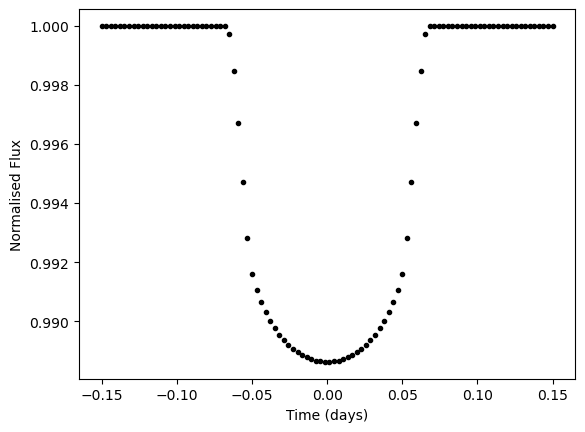

In [4]:
from luas.exoplanet import transit_light_curve

# Let's use the literature values used in Gibson et al. (2017) to start us off
mfp = {
    "T0":0.,     # Central transit time
    "P":3.4,     # Period (days)
    "a":8.,      # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1,   # Radius ratio rho aka Rp/R*
    "b":0.5,     # Impact parameter
    "u1":0.5,    # First quadratic limb darkening coefficient
    "u2":0.1,    # Second quadratic limb darkening coefficient
    "Foot":1.,   # Baseline flux out of transit
    "Tgrad":0.   # Gradient in baseline flux (hrs^-1)
}

# Generate 100 evenly spaced time points (in units of days)
N_t = 100
x_t = jnp.linspace(-0.15, 0.15, N_t)

plt.plot(x_t, transit_light_curve(mfp, x_t), "k.")
plt.xlabel("Time (days)")
plt.ylabel("Normalised Flux")
plt.show()

Now we want to take our ``jax`` function which has been written to generate a 1D light curve in time and instead create separate light curves in each wavelength. We also will want to share some parameters between light curves (e.g. impact parameter b, system scale a/Rs) while varying other parameters for each wavelength (e.g. radius ratio Rp/Rs).

We could of course write a for loop but for loops can be slow to compile with ``jax``. A more efficient option is to make use of the ``jax.vmap`` function which allows us to "vectorise" our function from 1D to 2D:

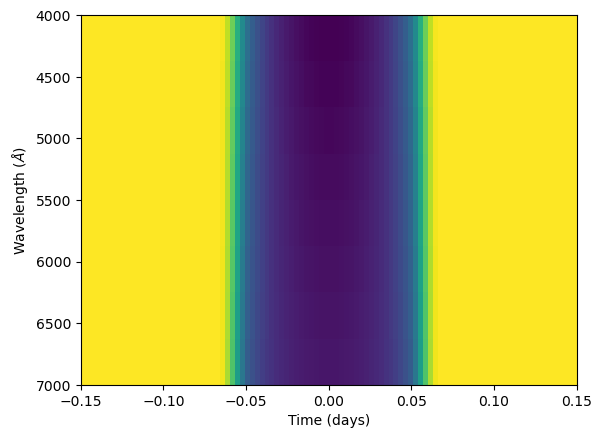

In [5]:
# First we must tell JAX which parameters of the function we want to vary for each light curve
# and which we want to be shared between light curves
transit_light_curve_vmap = jax.vmap(
    # First argument is the function to vectorise
    transit_light_curve, 
    
    # Specify which parameters to share and which to vary for each light curve
    in_axes=(
        {
        # If a parameter is to be shared across each light curve then it should be set to None
        "T0":None, "P":None, "a":None, "b":None,

        # Parameters which vary in wavelength are given the dimension of the array to expand along
        # In this case we are expanding from 0D arrays to 1D arrays so this must be 0
        "rho":0, "u1":0, "u2":0, "Foot":0, "Tgrad":0
        },
        # Also must specify that we will share the time array (the second function parameter)
        # between light curves
         None,  
    ),
    
    # Specify the output dimension to expand along, this will default to 0 anyway
    # Will output extra flux values for each light curve as additional rows
    out_axes = 0,
)

# Let's define a wavelength range of our data, this isn't actually used by our mean function
# but we will use it for defining correlation in wavelength later
N_l = 8 # Feel free to vary the number of light curves, even >100 light curves may perform quite efficiently
x_l = np.linspace(4000, 7000, N_l)

# Now we define our 2D transit parameters, let's just assume everything is constant in wavelength
mfp_2D = {
    "T0":0.,                         # Central transit time
    "P":3.4,                         # Period (days)
    "a":8.,                          # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1*np.ones(N_l),          # Radius ratio rho aka Rp/R*
    "b":0.5,                         # Impact parameter
    "u1":np.linspace(0.7, 0.4, N_l), # First quadratic limb darkening coefficient
    "u2":np.linspace(0.1, 0.2, N_l), # Second quadratic limb darkening coefficient
    "Foot":1.*np.ones(N_l),          # Baseline flux out of transit
    "Tgrad":0.*np.ones(N_l)          # Gradient in baseline flux (days^-1)
}

# Call our new vmap of transit_light_curve to simultaneously compute light curves for all wavelengths
transit_model_2D = transit_light_curve_vmap(mfp_2D, x_t)

# Visualise the transit light curves
plt.imshow(transit_model_2D, aspect = 'auto', extent = [x_t[0], x_t[-1], x_l[-1], x_l[0]])
plt.xlabel("Time (days)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

The form of a mean function with ``luas.GP`` is ``f(par, x_l, x_t)`` where ``par`` is a PyTree, ``x_l`` is a JAXArray of inputs that lie along the wavelength/vertical dimension of the data (e.g. an array of wavelength values) and ``x_t`` is a JAXArray of inputs that lie along the time/horizontal dimension (e.g. an array of timestamps). Our transit model does not require wavelength values to be computed but we still write our wrapper function to be of this form.

We will also switch to the [Kipping (2013)](https://arxiv.org/abs/1308.0009) limb darkening parameterisation as it makes it easier to place simple bounds on these parameters and has the benefit of placing a uniform prior on the physically allowed space of limb darkening parameters.

Also feel free to use the ``luas.exoplanet.transit_2D`` function instead which is similar to the below function with the exception that it fits for transit depth $d = \rho^2$ instead of radius ratio $\rho$

In [6]:
from luas.exoplanet import ld_to_kipping, ld_from_kipping

def transit_light_curve_2D(p, x_l, x_t):
    
    # vmap requires that we only input the parameters which have been explicitly defined how they vectorise
    transit_params = ["T0", "P", "a", "rho", "b", "Foot", "Tgrad"]
    mfp = {k:p[k] for k in transit_params}
    
    # Calculate limb darkening coefficients from the Kipping (2013) parameterisation.
    mfp["u1"], mfp["u2"] = ld_from_kipping(p["q1"], p["q2"])
    
    # Use the vmap of transit_light_curve to calculate a 2D array of shape (M, N) of flux values
    # For M wavelengths and N time points.
    return transit_light_curve_vmap(mfp, x_t)


# Switch to Kipping parameterisation
if "u1" in mfp_2D:
    mfp_2D["q1"], mfp_2D["q2"] = ld_to_kipping(mfp_2D["u1"], mfp_2D["u2"])
    del mfp_2D["u1"]
    del mfp_2D["u2"]

# This should produce the same result as transit_light_curve_vmap as we have only changed the limb darkening parameterisation
M = transit_light_curve_2D(mfp_2D, x_l, x_t)

Now that we have our mean function created, it's time to start building a kernel function. We will try keep things simple and use a squared exponential kernel for correlation in both time and wavelength, and white noise which varies in amplitude between different light curves.

$$
\begin{equation}
\mathbf{K}_{ij} = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right) + \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j} \delta_{t_i t_j}
\end{equation}
$$

This kernel contains a correlated noise component with height scale $h$, length scale in wavelength $l_\mathrm{\lambda}$ and length scale in time $l_t$. There is also a white noise term which can have different white noise amplitudes at different wavelengths.

We will need to write this kernel as separate wavelength and time kernel functions multiplied together satisfying:

$$
\begin{equation}
\text{K}(\Delta \lambda, \Delta t) = \text{K}_{l}(\Delta \lambda) \otimes \text{K}_{t}(\Delta t) + \text{S}_{l}(\Delta \lambda) \otimes \text{S}_{t}(\Delta t)
\end{equation}
$$

We can do this by choosing the equations below for our kernel functions which generate each component matrix.

$$
\begin{equation}
    \text{K}_l(\lambda_i, \lambda_j) = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) 
\end{equation}
$$

$$
\begin{equation}
    \text{K}_t(t_i, t_j) = \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right)
\end{equation}
$$

$$
\begin{equation}
    \text{S}_l(\lambda_i, \lambda_j) = \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j}
\end{equation}
$$

$$
\begin{equation}
    \text{S}_t(t_i, t_j) = \delta_{t_i t_j}
\end{equation}
$$

Note that for numerical stability reasons it's important that the $S_l$ and $S_t$ matrices are well-conditioned (i.e. can be stably inverted) while $K_l$ and $K_t$ do not need to be well-conditioned (or even invertible). The matrices which contain values added along the diagonal should be well-conditioned as this "regularises" the matrices, while a squared exponential kernel with nothing added along the diagonal is unlikely to be well-conditioned.

In [7]:
from luas import kernels
from luas import LuasKernel

# We implement each of these kernel functions below using the luas.kernels module
# for an implementation of the squared exponential kernel

def Kl_fn(hp, x_l1, x_l2, wn = True):
    Kl = jnp.exp(2*hp["log_h"])*kernels.squared_exp(x_l1, x_l2, jnp.exp(hp["log_l_l"]))
    return Kl

def Kt_fn(hp, x_t1, x_t2, wn = True):
    return kernels.squared_exp(x_t1, x_t2, jnp.exp(hp["log_l_t"]))

# For both the Sl and St functions we set a decomp attribute to "diag" because they produce diagonal matrices
# This speeds up the log likelihood calculations as it tells luas these matrices are easy to eigendecompose
# But don't do this for the Kl and Kt functions even if they produce diagonal matrices unless you know what you are doing
# This is because you are telling luas that the transformations of Kl and Kt are diagonal, not Kl and Kt themselves

def Sl_fn(hp, x_l1, x_l2, wn = True):
    Sl = jnp.zeros((x_l1.shape[-1], x_l2.shape[-1]))
    if wn:
        Sl += jnp.diag(jnp.exp(2*hp["log_sigma"]))

    return Sl
Sl_fn.decomp = "diag" # Sl is a diagonal matrix

def St_fn(p, x_t1, x_t2, wn = True):
    return jnp.eye(x_t1.shape[-1])
St_fn.decomp = "diag" # St is a diagonal matrix

# Build a LuasKernel object using these component kernel functions
# The full covariance matrix applied to the data will be K = Kl KRON Kt + Sl KRON St
kernel = LuasKernel(Kl = Kl_fn, Kt = Kt_fn, Sl = Sl_fn, St = St_fn,
                    
                    # Can select whether to use previously calculated eigendecompositions when running MCMC
                    # Performs an additional check in each step to see if each component covariance matrix has changed since last step
                    # Useful when doing blocked Gibbs or if fixing some hyperparameters
                    use_stored_values = True, 
                   )

The ``LuasKernel.visualise_covariance_matrix`` method should be a useful way of visualising each of the four component matrices and ensure everything you have written looks right

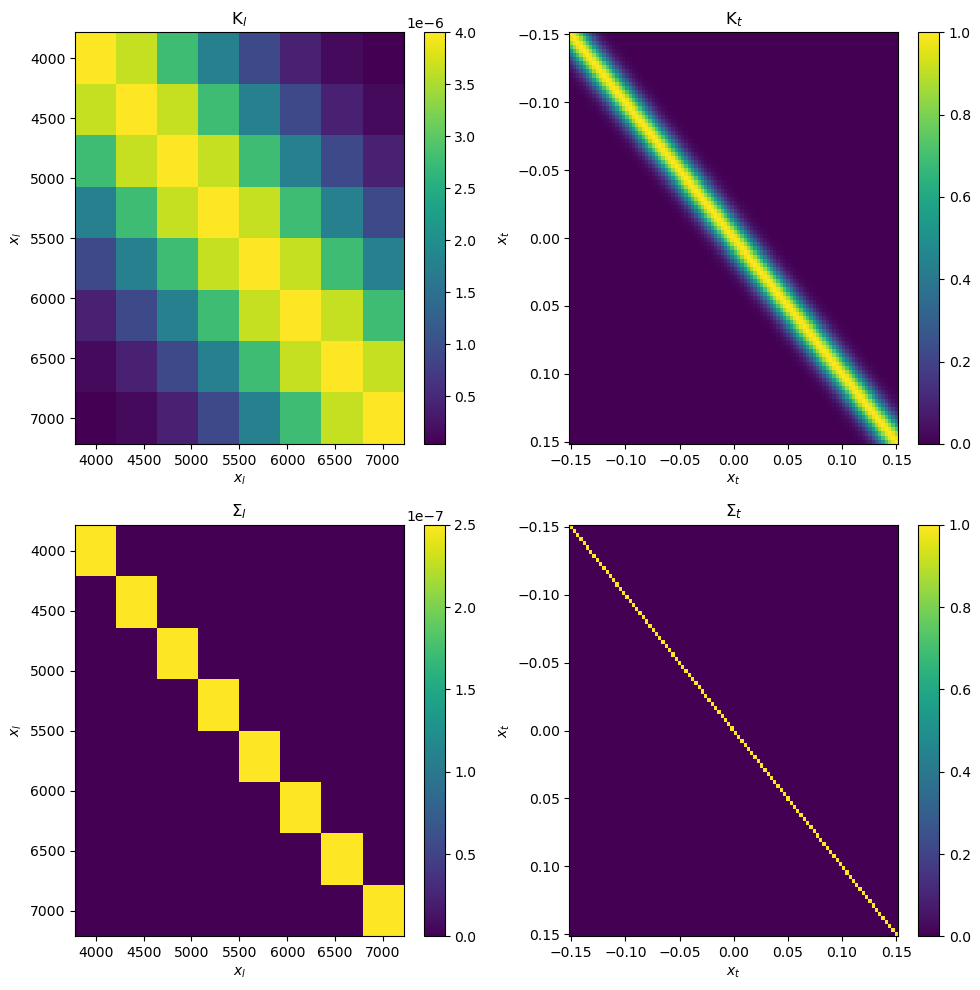

In [8]:
hp = {
    "log_h":np.log(2e-3),
    "log_l_l":np.log(1000.),
    "log_l_t":np.log(0.011),
    "log_sigma":np.log(5e-4)*np.ones(N_l),
}

kernel.visualise_covariance_matrix(hp, x_l, x_t);

Take a random noise draw from this covariance matrix. Try playing around with these values to see the effect varying each parameter has on the noise generated.

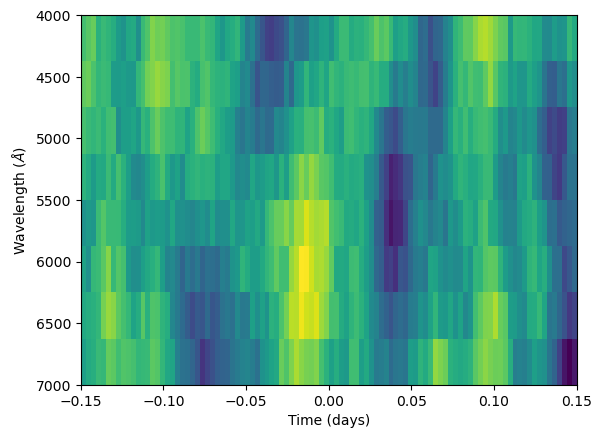

In [9]:
hp = {"log_h":jnp.log(2e-3),
      "log_l_l":jnp.log(1000.), 
      "log_l_t":jnp.log(0.011),
      "log_sigma":jnp.log(5e-4)*jnp.ones(N_l),}

sim_noise = kernel.generate_noise(hp, x_l, x_t)

plt.imshow(sim_noise, aspect = 'auto', extent = [x_t[0], x_t[-1], x_l[-1], x_l[0]])
plt.xlabel("Time (days)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

Combining our light curves and noise model we can generate synthetic light curves contaminated by systematics correlated in time and wavelength

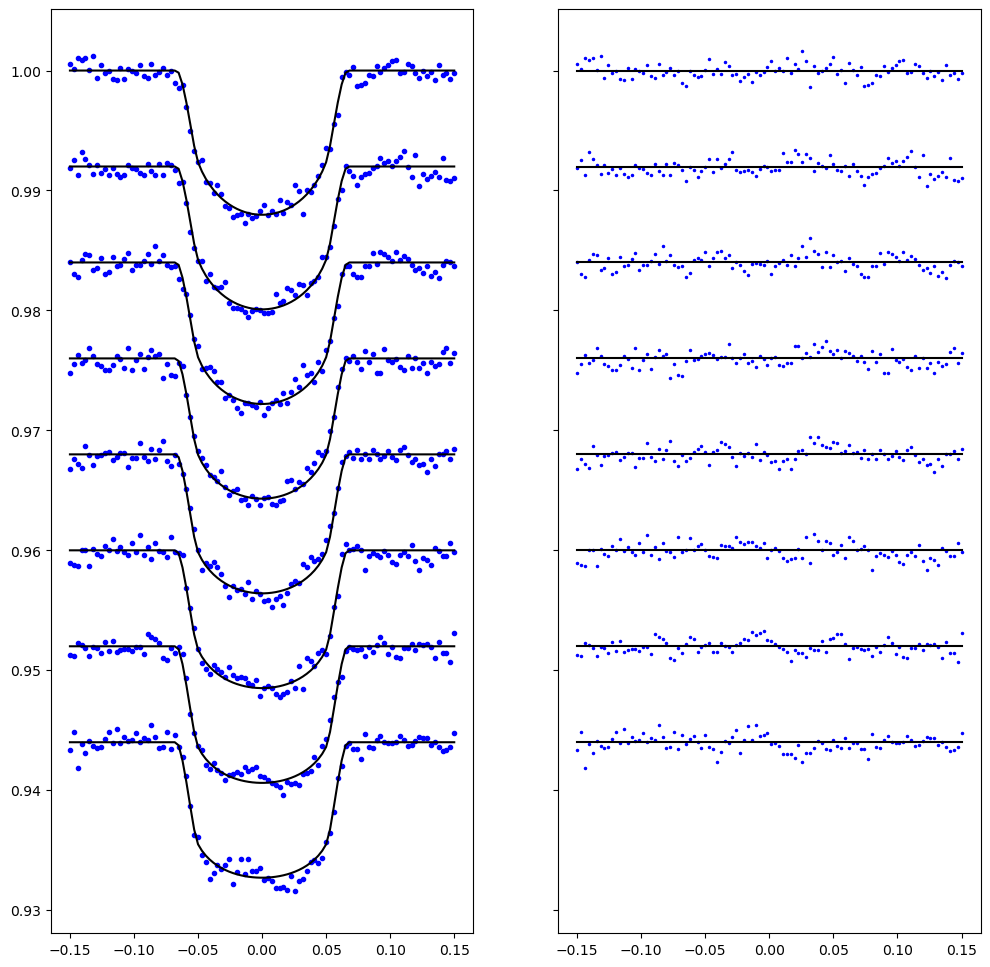

In [10]:
def plot_lightcurves(x_t, M, Y, sep = 0.008):
    """Quick function to visualise light curves and the residuals after subtraction of transit model
    
    """
    N_l = x_l.shape[-1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), sharey = True)
    for i in range(N_l):
        ax1.plot(x_t, Y[i, :] + np.arange(0, -sep*N_l, -sep)[i], 'bo', ms = 3)
        
        ax1.plot(x_t, M[i, :] + np.arange(0, -sep*N_l, -sep)[i], 'k-', ms = 3)
        ax2.plot(x_t, Y[i, :] - M[i, :] + np.arange(1, 1-sep*N_l, -sep)[i], 'b.', ms = 3)
        ax2.plot(x_t, np.arange(1, 1-sep*N_l, -sep)[i]*np.ones_like(x_t), 'k-', ms = 3)

u1_sim, u2_sim = np.linspace(0.7, 0.4, N_l), np.linspace(0.1, 0.2, N_l)
q1_sim, q2_sim = ld_to_kipping(u1_sim, u2_sim)

# All parameters used to generate the synthetic data set with noise
# PyMC will not work with jax arrays as inputs so we are using NumPy arrays
# Our PyMC wrapper also assumes that each input is an array so convert floats to size 1 NumPy arrays
p_sim = {
    # Mean function parameters
    "T0":0.*np.ones(1),                      # Central transit time
    "P":3.4*np.ones(1),                      # Period (days)
    "a":8.*np.ones(1),                       # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1*np.ones(N_l),                  # Radius ratio rho aka Rp/R* for each wavelength
    "b":0.5*np.ones(1),                      # Impact parameter
    "q1":q1_sim,                              # First quadratic limb darkening coefficient for each wavelength
    "q2":q2_sim,                              # Second quadratic limb darkening coefficient for each wavelength
    "Foot":1.*np.ones(N_l),                  # Baseline flux out of transit for each wavelength
    "Tgrad":0.*np.ones(N_l),                 # Gradient in baseline flux for each wavelength (days^-1)
    
    # Hyperparameters
    "log_h":np.log(5e-4)*np.ones(1),        # log height scale
    "log_l_l":np.log(1000.)*np.ones(1),     # log length scale in wavelength
    "log_l_t":np.log(0.011)*np.ones(1),     # log length scale in time
    "log_sigma":np.log(5e-4)*np.ones(N_l),  # log white noise amplitude for each wavelength
}

transit_signal = transit_light_curve_2D(p_sim, x_l, x_t)
sim_noise = kernel.generate_noise(p_sim, x_l, x_t)
Y = transit_signal*(1 + sim_noise)

plot_lightcurves(x_t, transit_signal, Y)

We may also want to define a logPrior function. While PyMC can also be used to define priors on parameters, it can be useful to let ``luas.GP`` handle non-uniform priors when it comes to MCMC tuning (as will be shown later).

The ``logPrior`` function input to ``luas.GP`` should be written in JAX and must be of the form ``logPrior(params)`` i.e. it may only take the PyTree of mean function parameters and hyperparameters as input.

In [11]:
a_mean = p_sim["a"]
a_std = 0.1
b_mean = p_sim["b"]
b_std = 0.01

# Set some limb darkening priors, normally these might be generated from a package like LDTk
u1_mean = u1_sim
u1_std = 0.01
u2_mean = u2_sim
u2_std = 0.01

def logPrior(p):
    logPrior = -0.5*((p["a"] - a_mean)/a_std)**2
    logPrior += -0.5*((p["b"] - b_mean)/b_std)**2
    
    u1, u2 = ld_from_kipping(p["q1"], p["q2"])
    u1_priors = -0.5*((u1 - u1_mean)/u1_std)**2
    u2_priors = -0.5*((u2 - u2_mean)/u2_std)**2
    
    logPrior += u1_priors.sum() + u2_priors.sum()

    return logPrior.sum()

print("Log prior at simulated values:", logPrior(p_sim))

Log prior at simulated values: -1.0400021699691074e-28


We now have enough to define our ``luas.GP`` object and use it to try recover the original transmission signal injected into the correlated noise.

Starting log posterior value: 4856.259628014549


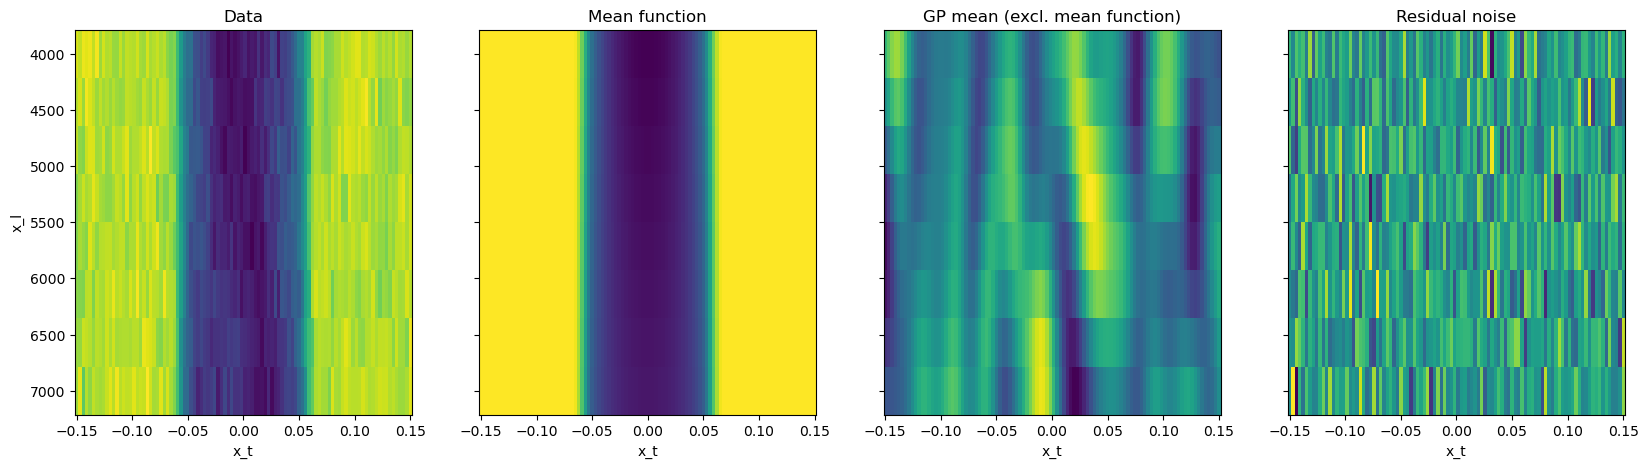

In [12]:
from luas import GP
from copy import deepcopy

# Initialise our GP object
# Make sure to include the mean function and log prior function if you're using them
gp = GP(kernel,  # Kernel object to use
        x_l,     # Regression variable(s) along wavelength/vertical dimension
        x_t,     # Regression variable(s) along time/horizontal dimension
        mf = transit_light_curve_2D,  # (optional) mean function to use, defaults to zeros
        logPrior = logPrior           # (optional) log prior function, defaults to zero
       )

# Initialise our starting values as the true simulated values
p_initial = deepcopy(p_sim)

# Convenient function for plotting the data and the GP fit to the data
gp.plot(p_initial, Y)
print("Starting log posterior value:", gp.logP(p_initial, Y))

Now let's begin using PyMC to perform a best-fit. We've set the true simulated values as our initial values so we should already be close to the optimal log posterior value but for real data this won't always be the case. Similar to the approach in Fortune et al. (2024) we will not be performing any white light curve analysis but instead will be joint-fitting all spectroscopic light curves simultaneously.

In [13]:
import pymc as pm
from luas.pymc_ext import LuasPyMC

# Let's define some bounds
min_log_l_l = np.log(np.diff(x_l).min())
max_log_l_l = np.log(50*(x_l[-1] - x_l[0]))
min_log_l_t = np.log(np.diff(x_t).min())
max_log_l_t = np.log(3*(x_t[-1] - x_t[0]))

# Note with PyMC that the parameter bounds must also be NumPy arrays
param_bounds = {
                # Bounds from Kipping (2013) at just between 0 and 1
                "q1":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "q2":[np.array([0.]*N_l), np.array([1.]*N_l)],
    
                # Can optionally include bounds on other mean function parameters but often they will be well constrained by the data
                "rho":[np.array([0.]), np.array([1.]*N_l)],
    
                # Sometimes prior bounds on hyperparameters are important for sampling
                # However their choice can sometimes affect the results so use with caution
                "log_h":   [np.log(1e-6)*np.ones(1), np.log(1)*np.ones(1)],
                "log_l_l": [min_log_l_l*np.ones(1), max_log_l_l*np.ones(1)],
                "log_l_t": [min_log_l_t*np.ones(1), max_log_l_t*np.ones(1)],
                "log_sigma":[np.log(1e-6)*np.ones(N_l), np.log(1e-2)*np.ones(N_l)],
}

# Make a wrapper function which returns a PyMC model with a given set of fixed parameters and observations Y
def transit_model(p_fixed, Y):
    
    with pm.Model() as model:

        # Makes of copy of any parameters to be kept fixed during sampling
        var_dict = deepcopy(p_fixed)
        
        # Specify the parameters we've given bounds for
        var_dict["rho"] = pm.Uniform('rho', lower=param_bounds["rho"][0],   upper=param_bounds["rho"][1], shape=N_l)
        var_dict["q1"] = pm.Uniform('q1', lower=param_bounds["q1"][0],   upper=param_bounds["q1"][1], shape=N_l)
        var_dict["q2"] = pm.Uniform('q2', lower=param_bounds["q2"][0],   upper=param_bounds["q2"][1], shape=N_l)
        var_dict["log_h"] =   pm.Uniform("log_h", lower=param_bounds["log_h"][0], upper=param_bounds["log_h"][1], shape=1)
        var_dict["log_l_l"] = pm.Uniform("log_l_l", lower = param_bounds["log_l_l"][0], upper = param_bounds["log_l_l"][1],
                                         shape=1)
        var_dict["log_l_t"] = pm.Uniform("log_l_t", lower = param_bounds["log_l_t"][0], upper = param_bounds["log_l_t"][1],
                                         shape=1)
        var_dict["log_sigma"] = pm.Uniform('log_sigma', lower=param_bounds["log_sigma"][0], upper=param_bounds["log_sigma"][1],
                                           shape=N_l)
        
        # Specify the unbounded parameters
        var_dict["T0"] = pm.Flat('T0', shape=1)
        var_dict["a"] = pm.Flat('a', shape=1)
        var_dict["b"] = pm.Flat('b', shape=1)
        var_dict["Foot"] = pm.Flat('Foot', shape=N_l)
        var_dict["Tgrad"] = pm.Flat('Tgrad', shape=N_l)

        # PyMC wrapper for luas log posterior calculations
        # Requires the gp object, a dictionary of each model parameter and the observations Y
        LuasPyMC("log_like", gp = gp, var_dict = var_dict, Y = Y)
        
    # Will need to return both the model and the model variables for inference
    return model, var_dict

# Initialise our model, p_initial will specify any fixed values like the period P
model, var_dict = transit_model(p_initial, Y)

Now we are all set up to start performing a best-fit using ``PyMC``.

In [14]:
# PyMC requires the dictionary of starting values to only include variables in the model
# So we must remove the period parameter P as we keep it fixed
p_pymc = deepcopy(p_initial)
del p_pymc["P"]

# Use PyMC's maximum posteriori optimisation function
map_estimate = pm.find_MAP(
    model = model,               # PyMC model to optimise
    include_transformed = False, # If this is true it will also output the PyMC transformed values of bounded parameters
    start = p_pymc,              # Starting point of optimisations
    maxeval = 30000,             # Maximum steps to run (normally will converge before this)
)

# Create a new dictionary of optimised values which includes our fixed parameters
p_opt = deepcopy(p_initial)
p_opt.update(map_estimate)

print("Starting log posterior value:", gp.logP(p_initial, Y))
print("New optimised log posterior value:", gp.logP(p_opt, Y))


Starting log posterior value: 4856.259628014549
New optimised log posterior value: 4869.998566626245


Although this probably won't be needed for the simulated data and will likely clip no data points, ``luas.GP`` comes with a ``sigma_clip`` method which performs 2D Gaussian process regression and can clip outliers that deviate from a given significance value and replace them with the GP predictive mean at those locations (note we need to maintain a complete grid structure and cannot remove these data points).

Number of outliers clipped =  0


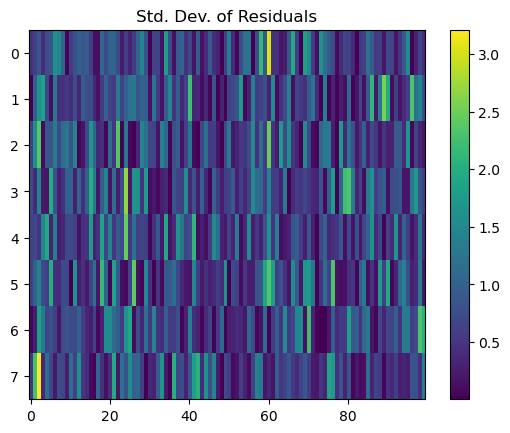

In [15]:
# This function will return a JAXArray of the same shape as Y
# but with outliers replaced with interpolated values
Y_clean = gp.sigma_clip(p_opt, # Make sure to perform sigma clipping using a good fit to the data
                        Y,     # Observations JAXArray
                        5.     # Significance level in standard deviations to clip at
                       )

For MCMC tuning with large numbers of parameters, it can be very helpful to use the Laplace approximation to select a good choice of tuning matrix or "mass matrix" for No U-Turn Sampling (NUTS). This can often return quite accurate approximations of the covariance matrix of the posterior - especially when most of the parameters are well constrained.

If outliers were clipped then optimisation may need to be ran again on the cleaned data before running this step as the Laplace approximation should be performed at the maximum of the posterior. Also note that we use the ``gp.laplace_approx_with_bounds`` method instead of ``gp.laplace_approx`` because we have bounds on some of our parameters which means ``PyMC`` will perform a transformation on these parameters we would like our Laplace approximation to take account of. See the ``gp.laplace_approx_with_bounds`` documentation for more details.

In [16]:
# Returns the covariance matrix returned by the Laplace approximation
# Also returns a list of parameters which is the order the array is in
# This matches the way jax.flatten_util.ravel_pytree will sort the parameter PyTree into
cov_mat, ordered_param_list = gp.laplace_approx_with_bounds(
    p_opt,               # Make sure to use best-fit values
    Y_clean,             # The observations being fit
    param_bounds,        # Specify the same bounds that will be used for the MCMC
    fixed_vars = ["P"],  # Make sure to specify fixed parameters as otherwise they are marginalised over
    return_array = True, # May optionally return a nested PyTree if set to False which can be more readable
    regularise = True,   # Often necessary to regularise values that return negative covariance
    large = False,       # Setting this to True is more memory efficient which may be needed for large data sets
)

# This function will output information on what regularisation has been performed
# And will mention if there are remaining negative values along the diagonal of the covariance matrix
# It does not however check if the covariance matrix is invertible

No regularisation needed to remove negative values along diagonal of covariance matrix.


Build our model again using the same parameters being varied and sample all parameters using NUTS. Note that ``PyMC`` has far more options for sampling here and can easily do blocked Gibbs sampling with multiple NUTS steps or you can intermix NUTS sampling with other methods such as slice sampling, etc.

PyMC appears to be unable to run JAX functions in parallel which is why ``cores = 1`` has been set. If wanting to run in parallel then the current suggestion is to run separate programs in parallel which each runs a chain with ``PyMC`` and save each ``arviz`` inference data object separately. These can later by loaded in and combined with ``arviz.concat``

In [17]:
# Initialise our PyMC model
model, var_dict = transit_model(p_opt, Y_clean)

# The NUTS step takes as input the variables created when initialising the model
# We also sort these variables in the same order our Laplace approximated covariance matrix is in
NUTS_model_vars = [var_dict[par] for par in ordered_param_list]
NUTS_step = pm.NUTS(NUTS_model_vars, scaling = cov_mat, is_cov = True, model = model)

# Begin MCMC sampling
idata = pm.sample(
    model = model,           # PyMC model to sample
    step = NUTS_step,        # Sampling steps to use (can be list for blocked Gibbs sampling)
    initvals = map_estimate, # Starting point of inference (will jitter around this location)
    draws = 1000,            # Number of samples from MCMC post warm-up
    tune = 1000,             # Number of tuning steps
    chains = 2,              # Number of chains to run
    cores = 1,               # This will probably fail if not set to 1 as I don't think PyMC can parallelise JAX functions
)

# Saves the inference object
#idata.to_json("MCMC_chains.json");

INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [Foot, T0, Tgrad, a, b, log_h, log_l_l, log_l_t, log_sigma, q1, q2, rho]


INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 633 seconds.


Print a summary of the samples using ``arviz``. Important values to look at for convergence are that the effective sample size of the bulk of the distribution (``ess_bulk``) and the tail of the distribution (``ess_tail``) are at least ~500-1000 and that the Gelman-Rubin ``r_hat`` statistic is less than ~1.01 for each parameter.

In [18]:
az.summary(idata, round_to = 4)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
T0[0]         0.0003  0.0003 -0.0003   0.0009     0.0000   0.0000  2078.0299   
a[0]          8.0201  0.0577  7.9137   8.1311     0.0009   0.0006  4165.9975   
b[0]          0.4993  0.0087  0.4838   0.5157     0.0001   0.0001  4568.4657   
Foot[0]       0.9999  0.0002  0.9995   1.0002     0.0000   0.0000  3314.7297   
Foot[1]       0.9997  0.0002  0.9993   1.0000     0.0000   0.0000  3481.3768   
Foot[2]       0.9998  0.0002  0.9994   1.0001     0.0000   0.0000  3152.8017   
Foot[3]       0.9997  0.0002  0.9994   1.0001     0.0000   0.0000  3321.4162   
Foot[4]       0.9998  0.0002  0.9995   1.0002     0.0000   0.0000  3240.9395   
Foot[5]       0.9998  0.0002  0.9994   1.0001     0.0000   0.0000  3219.6892   
Foot[6]       0.9998  0.0002  0.9995   1.0002     0.0000   0.0000  3398.6596   
Foot[7]       1.0000  0.0002  0.9996   1.0003     0.0000   0.0000  3191.7547   
Tgrad[0]     -0.0000  0.0001 -0.0002   0.0001     0.0000   0.0000  2731.2787   
Tgrad[1]     -0.0000  0.0001 -0.0001   0.0001     0.0000   0.0000  2781.5598   
Tgrad[2]      0.0000  0.0001 -0.0001   0.0001     0.0000   0.0000  2444.1837   
Tgrad[3]      0.0001  0.0001 -0.0001   0.0002     0.0000   0.0000  2573.6955   
Tgrad[4]      0.0001  0.0001 -0.0001   0.0002     0.0000   0.0000  2716.6526   
Tgrad[5]     -0.0000  0.0001 -0.0001   0.0001     0.0000   0.0000  2622.7450   
Tgrad[6]      0.0000  0.0001 -0.0001   0.0001     0.0000   0.0000  2412.5490   
Tgrad[7]      0.0000  0.0001 -0.0001   0.0001     0.0000   0.0000  2326.2962   
rho[0]        0.0987  0.0014  0.0959   0.1014     0.0000   0.0000  2953.3417   
rho[1]        0.0973  0.0015  0.0947   0.1002     0.0000   0.0000  2820.8698   
rho[2]        0.0980  0.0014  0.0955   0.1009     0.0000   0.0000  2679.4756   
rho[3]        0.0974  0.0014  0.0947   0.1002     0.0000   0.0000  2950.8928   
rho[4]        0.0983  0.0014  0.0957   0.1006     0.0000   0.0000  3479.0272   
rho[5]        0.0983  0.0014  0.0954   0.1009     0.0000   0.0000  3530.0252   
rho[6]        0.0986  0.0014  0.0960   0.1013     0.0000   0.0000  3773.3036   
rho[7]        0.1009  0.0014  0.0984   0.1035     0.0000   0.0000  3155.6711   
q1[0]         0.6415  0.0221  0.6008   0.6859     0.0004   0.0003  2818.3832   
q1[1]         0.5887  0.0209  0.5507   0.6308     0.0004   0.0003  3389.4865   
q1[2]         0.5525  0.0200  0.5117   0.5866     0.0003   0.0002  4441.7553   
q1[3]         0.5139  0.0193  0.4759   0.5471     0.0003   0.0002  3099.8571   
q1[4]         0.4777  0.0188  0.4429   0.5111     0.0003   0.0002  4046.5404   
q1[5]         0.4275  0.0185  0.3946   0.4621     0.0003   0.0002  4652.2134   
q1[6]         0.3977  0.0169  0.3687   0.4321     0.0003   0.0002  3564.5236   
q1[7]         0.3584  0.0165  0.3268   0.3874     0.0003   0.0002  4077.2300   
q2[0]         0.4374  0.0055  0.4281   0.4487     0.0001   0.0001  3960.4172   
q2[1]         0.4268  0.0056  0.4165   0.4369     0.0001   0.0001  3342.4015   
q2[2]         0.4135  0.0056  0.4037   0.4246     0.0001   0.0001  3603.6529   
q2[3]         0.3997  0.0056  0.3896   0.4099     0.0001   0.0001  3788.2093   
q2[4]         0.3850  0.0055  0.3745   0.3960     0.0001   0.0001  4295.5469   
q2[5]         0.3699  0.0063  0.3579   0.3812     0.0001   0.0001  4557.6404   
q2[6]         0.3518  0.0059  0.3412   0.3631     0.0001   0.0001  3265.5559   
q2[7]         0.3334  0.0066  0.3215   0.3463     0.0001   0.0001  4362.3165   
log_h[0]     -7.7222  0.1468 -7.9825  -7.4427     0.0036   0.0026  1604.7539   
log_l_l[0]    6.9081  0.1538  6.5938   7.1718     0.0044   0.0031  1359.6407   
log_l_t[0]   -4.5539  0.1611 -4.8743  -4.2735     0.0045   0.0032  1346.7534   
log_sigma[0] -7.5954  0.0761 -7.7415  -7.4581     0.0012   0.0009  3961.3187   
log_sigma[1] -7.5929  0.0774 -7.7323  -7.4410     0.0013   0.0009  3637.4386   
log_sigma[2] -7.5848  0.0734 -7.7231  -7.4501     0.0013   0.0009  3018.8679   
log_sigma[3] -7.

The ``arviz.plot_trace`` function can be very useful for visualising the marginal posterior distributions of the different parameters as well as to examine the chains and diagnose any possible convergence issues.

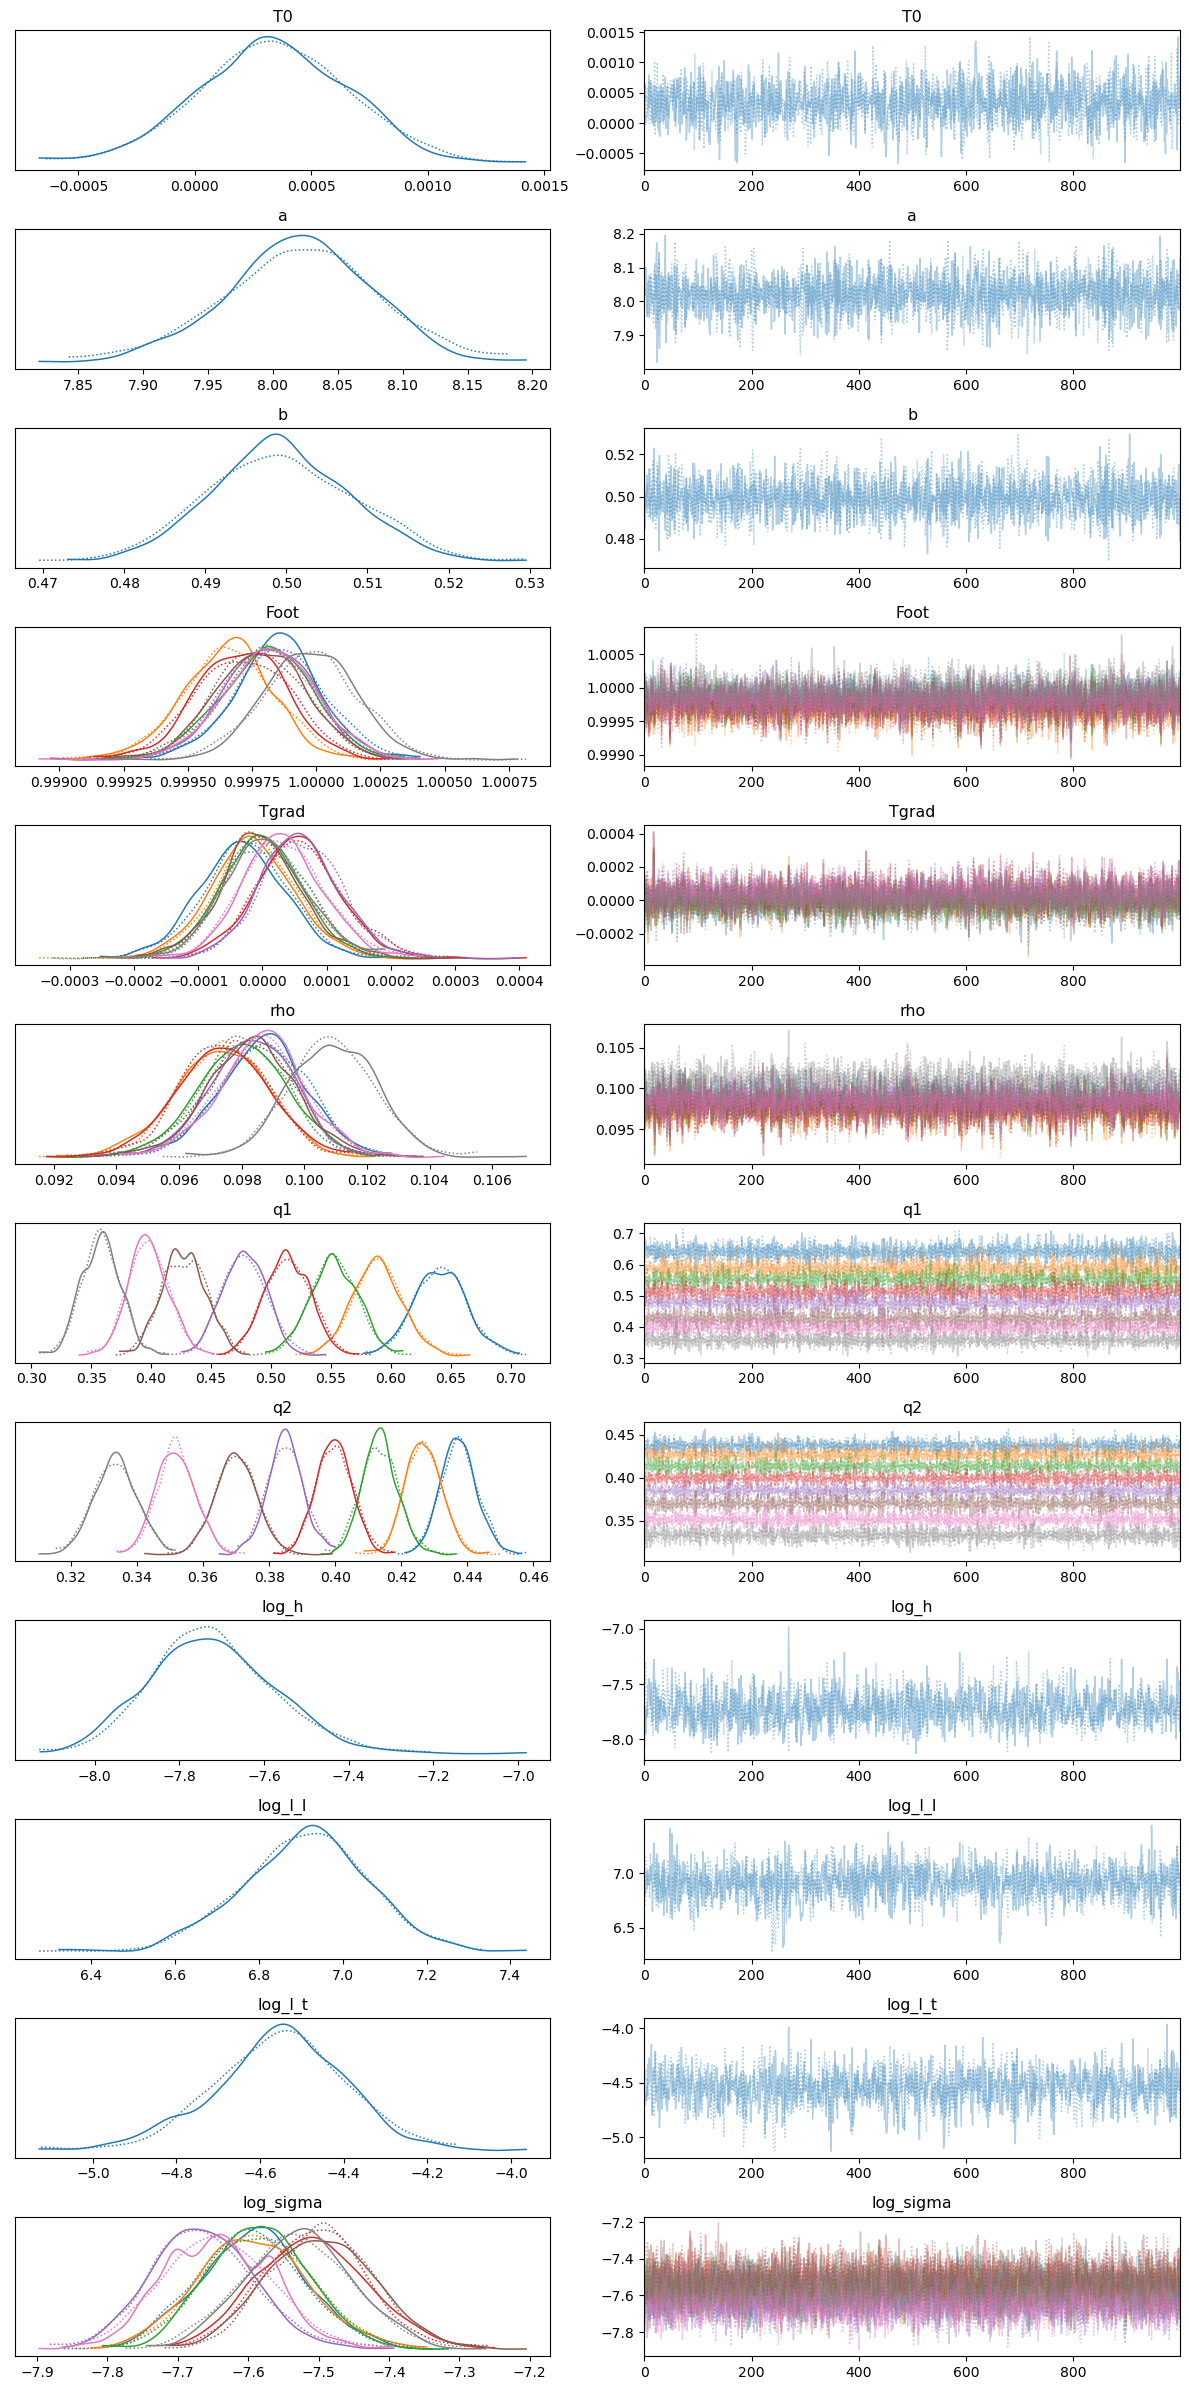

In [19]:
trace_plot = az.plot_trace(idata)
plt.tight_layout()

``corner`` is great for generating nice corner plots. Unfortunately when fitting many light curves the number of parameters can make visualising the full corner plot quite unwieldly but we can always just plot subsets of parameters instead.

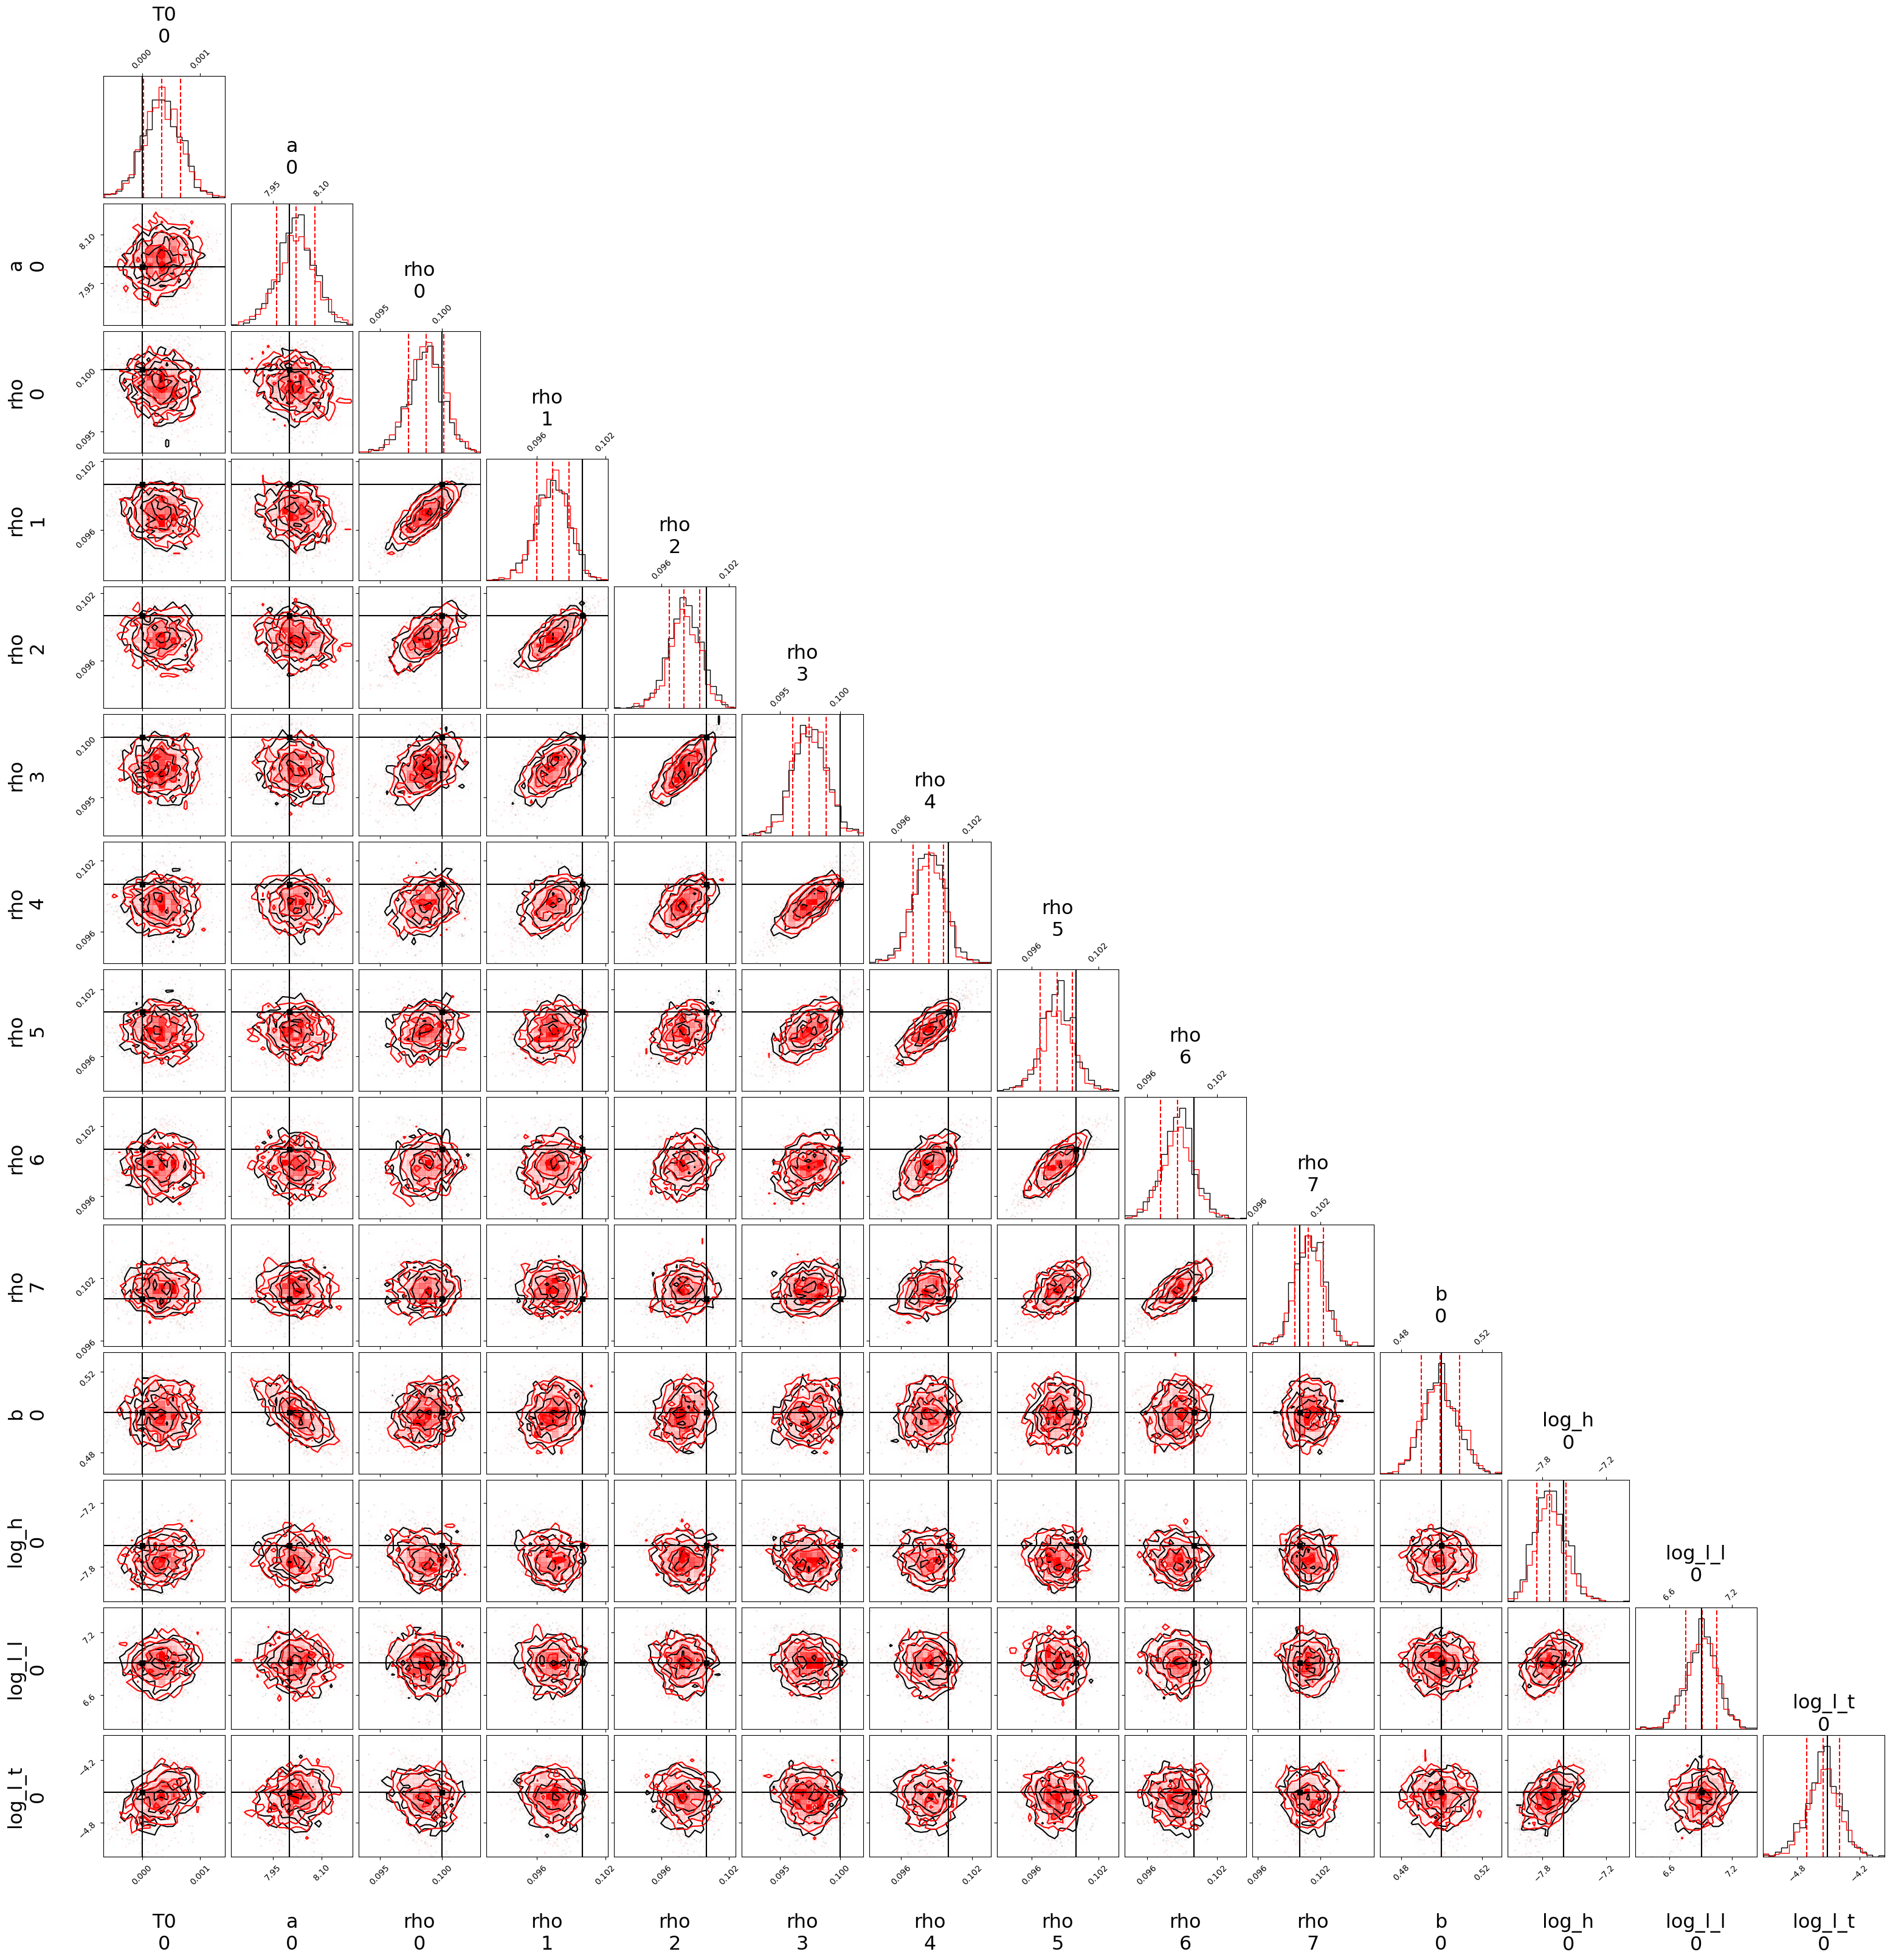

In [20]:
from corner import corner

# Select the parameters to include in the plot
params = ["T0", "a", "rho", "b", "log_h", "log_l_l", "log_l_t"]

# Plot each of the two chains separately
idata_corner1 = idata.sel(chain=[0])
idata_corner2 = idata.sel(chain=[1])

# Plot first chain
fig1 = corner(idata_corner1, smooth = 0.4, var_names = params)

# Plot second chain along with truth values
fig2 = corner(idata_corner2, quantiles=[0.16, 0.5, 0.84], title_fmt = None, title_kwargs={"fontsize": 23},
              label_kwargs={"fontsize": 23}, show_titles=True, smooth = 0.4, color = "r", fig = fig1,
              top_ticks = True, max_n_ticks = 2, labelpad = 0.16, var_names = params,
              truths = p_sim, truth_color = "k",
              )

If you want to examine the chains for any parameters you can use ``idata.posterior[param]`` to get an ``xarray.DataArray`` object and can use the ``to_numpy`` method to convert to a ``NumPy`` array. Below we retrieve the mean and covariance matrix of the radius ratio parameters and then visualise the transmission spectrum as well as the covariance matrix of the transmission spectrum.

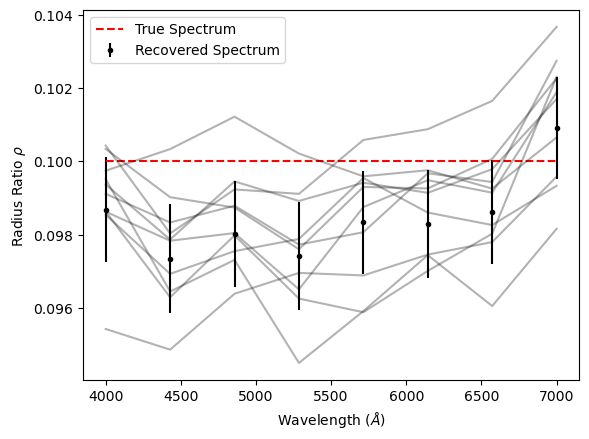

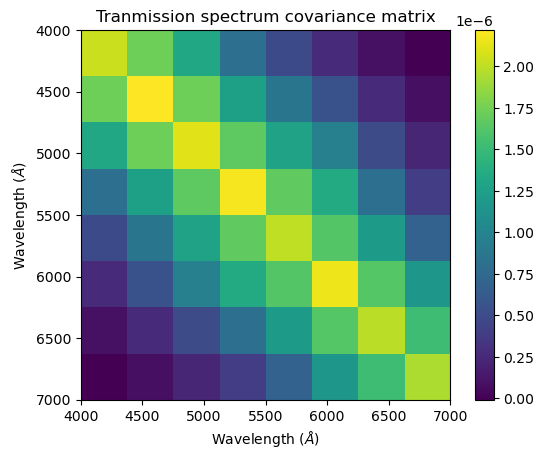

In [21]:
# NumPy array of MCMC samples of shape (N_chains, N_draws, N_l)
rho_chains = idata.posterior["rho"].to_numpy()

# Get the mean radius ratio values averaged over all chains and draws
rho_mean = rho_chains.mean((0, 1))

# Calculate the covariance matrix of each chain and average together
N_chains = rho_chains.shape[0]
rho_cov = jnp.zeros((N_l, N_l))
for i in range(N_chains):
    rho_cov += jnp.cov(rho_chains[0, :, :].T)
rho_cov /= N_chains

# Standard deviation given by sqrt of diagonal of covariance matrix
rho_std_dev = jnp.sqrt(jnp.diag(rho_cov))


# We can plot our recovered spectrum against the simulated true spectrum
plt.errorbar(x_l, rho_mean, yerr = rho_std_dev, fmt = 'k.', label = "Recovered Spectrum")
plt.plot(x_l, p_sim["rho"], 'r--', label = "True Spectrum")

# Select a few samples from the MCMC to help visualise the correlation between values
rho_draws = rho_chains[0, 0:1000:100, :].T
plt.plot(x_l, rho_draws, 'k-', alpha = 0.3)
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel(r"Radius Ratio $\rho$")
plt.legend()
plt.show()

plt.title("Tranmission spectrum covariance matrix")
plt.imshow(rho_cov, extent = [x_l[0], x_l[-1], x_l[-1], x_l[0]])
plt.colorbar()
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

It can be hard to tell when there are significant correlations involved whether the recovered spectrum is actually consistent with the simulated spectrum. The reduced chi-squared statistic $\chi_r^2$ is useful for determining this. It is calculated using:

$$
\begin{equation}
    \chi_\mathrm{r}^2 = (\bar{\vec{\rho}}_\mathrm{ret} - \vec{\rho}_\mathrm{inj})^T \mathbf{K}_\mathrm{\vec{\rho}; ret}^{-1} (\bar{\vec{\rho}}_\mathrm{ret} - \vec{\rho}_\mathrm{inj}) / N_l,
\end{equation}
$$

Where $\bar{\vec{\rho}}_\mathrm{ret}$ is our retrieved mean transmission spectrum, $\vec{\rho}_\mathrm{inj}$ is the injected transmission spectrum and $\mathbf{K}_\mathrm{\vec{\rho}; ret}$ is our retrieved covariance matrix of the transmission spectrum.

In [22]:
r = rho_mean - p_sim["rho"]
chi2_r = r.T @ jnp.linalg.inv(rho_cov) @ r / N_l

print("Reduced chi-squared value:", chi2_r)

# The reduced chi-squared distribution always has mean 1 but has different standard deviations
# depending on the numbers of degrees of freedom
print("Distribution of reduced chi-squared: mean = 1, std. dev. =", jnp.sqrt(2/N_l))

Reduced chi-squared value: 1.2522542727660981
Distribution of reduced chi-squared: mean = 1, std. dev. = 0.5
